In [1]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.62
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 3.36


In [2]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get cell list

In [4]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "VPM"
target = "SSp"
tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(target))
print([nmt.bs.id_to_name(i) for i in tid])

distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']


['SSp', 'SSp1', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a', 'SSp6b', 'SSp-n', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a', 'SSp-n6b', 'SSp-bfd', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b', 'VISrll', 'VISrll1', 'VISrll2/3', 'VISrll4', 'VISrll5', 'VISrll6a', 'VISrll6b', 'SSp-ll', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m', 'SSp-m1', 'SSp-m2/3', 'SSp-m4', 'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4', 'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr', 'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un', 'SSp-un1', 'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b']


In [5]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Manually_corrected_soma_region'].isin([group])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata = metadata[['brain', 'creline']]
nlist = metadata.index.tolist()

metadata.head()


,brain,creline
17302_00037,17302,Tnnt1
17302_00053,17302,Tnnt1
17302_00054,17302,Tnnt1
17302_00112,17302,Tnnt1
17302_00113,17302,Tnnt1


In [6]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [7]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00037,7026.350,3690.850,3451.175
17302_00053,6642.675,4085.425,4045.825
17302_00054,7237.100,4146.150,4213.075
17302_00112,7131.200,4042.150,3576.050
17302_00113,6678.825,3612.900,3498.700


## Axon

In [8]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
# cc = ca.loc[cc]
# cc

In [9]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
# for i in ['17545_00054']:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
        axon_dict.update({i:cswc})
        axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]

print(len(nlist), len(nlist_selected))

17545_00169:	0.10mm
18454_00067:	0.76mm
18454_00139:	0.47mm
18454_00153:	0.54mm
18454_01032:	0.74mm
18454_01095:	0.72mm
18454_01096:	0.08mm
18454_01104:	0.22mm
18454_01125:	0.37mm
18455_00256:	0.00mm
18455_00257:	0.00mm
18457_00019:	0.73mm
18457_00025:	0.00mm
18457_00029:	0.64mm
18457_00051:	0.00mm
18457_00054:	0.66mm
18457_00061:	0.11mm
18457_00062:	0.53mm
18462_00061:	0.00mm
18463_00058:	0.00mm
18465_00229:	0.10mm
18465_00234:	0.00mm
378 356


## distance soma v.s. axon

In [10]:
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



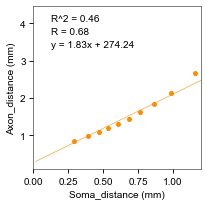

In [11]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0,1.2))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_"+group+"_v2.pickle", 'wb'))

## Axon overlaps

Merging child region SSp into region SSp
Merging child region SSp1 into region SSp
Merging child region SSp2/3 into region SSp
Merging child region SSp4 into region SSp
Merging child region SSp5 into region SSp
Merging child region SSp6a into region SSp
Merging child region SSp6b into region SSp
Merging child region SSp-n into region SSp
Merging child region SSp-n1 into region SSp
Merging child region SSp-n2/3 into region SSp
Merging child region SSp-n4 into region SSp
Merging child region SSp-n5 into region SSp
Merging child region SSp-n6a into region SSp
Merging child region SSp-n6b into region SSp
Merging child region SSp-bfd into region SSp
Merging child region SSp-bfd1 into region SSp
Merging child region SSp-bfd2/3 into region SSp
Merging child region SSp-bfd4 into region SSp
Merging child region SSp-bfd5 into region SSp
Merging child region SSp-bfd6a into region SSp
Merging child region SSp-bfd6b into region SSp
Merging child region VISrll into region SSp
Merging child region VI

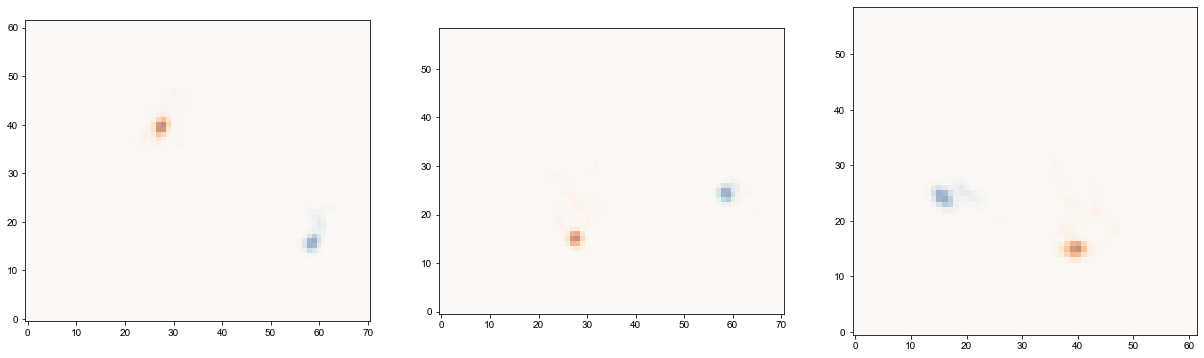

In [12]:
# Get subvolumn
region_id = nmt.bs.name_to_id(target)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [13]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

In [14]:
overlap_df

,17302_00037,17302_00053,17302_00054,17302_00112,17302_00113,17302_00114,17302_00115,17545_00054,17545_00055,17545_00056,...,18465_00230,18465_00241,18465_00243,18465_00261,18465_00286,18465_00287,18465_00288,18465_00292,18465_00294,18465_00304
17302_00037,1,1.95009e-99,5.95709e-111,8.67323e-18,2.09108e-12,7.55487e-06,0.0042467,1.84312e-18,0.00531975,2.87149e-09,...,0.000255466,3.89072e-43,1.15555e-107,1.76851e-98,2.04645e-42,1.77905e-101,1.00695e-76,1.54576e-15,6.037e-74,3.26677e-191
17302_00053,1.95009e-99,1,0.0240662,6.25435e-35,2.1828e-28,1.92426e-28,4.78878e-56,1.86474e-28,4.07437e-50,3.57814e-37,...,1.5556e-50,0.00294739,0.212736,0.0230082,1.39828e-08,0.0239715,0.00396644,1.89035e-33,0.000165952,0.00479252
17302_00054,5.95709e-111,0.0240662,1,1.10036e-31,2.25676e-40,5.21822e-18,4.71726e-45,3.4258e-37,4.79984e-78,1.02143e-40,...,4.70772e-48,3.57997e-15,0.00107932,8.04461e-09,5.54874e-14,9.09138e-09,8.85795e-05,4.6224e-23,0.00334866,0.0262273
17302_00112,8.67323e-18,6.25435e-35,1.10036e-31,1,6.88234e-07,0.000134647,0.00169498,1.53942e-07,2.84348e-15,0.000287889,...,0.000573091,6.13799e-12,1.38094e-35,4.35704e-34,6.14547e-09,7.92799e-35,5.7802e-18,0.00319717,1.95614e-14,3.63687e-96
17302_00113,2.09108e-12,2.1828e-28,2.25676e-40,6.88234e-07,1,0.00280269,2.03268e-07,0.169074,0.0342321,0.0258252,...,0.00498403,3.97351e-08,1.23815e-33,9.42593e-24,1.68268e-05,7.92423e-25,9.68844e-25,0.00106826,6.9894e-10,8.91602e-66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00287,1.77905e-101,0.0239715,9.09138e-09,7.92799e-35,7.92423e-25,9.03106e-32,7.20919e-62,1.00681e-28,7.58622e-51,8.30516e-37,...,1.20789e-47,0.000688929,0.00126,0.907287,0.000878395,1,0.321487,2.18384e-30,0.00303903,2.50554e-14
18465_00288,1.00695e-76,0.00396644,8.85795e-05,5.7802e-18,9.68844e-25,6.20886e-14,1.64405e-35,1.02734e-22,2.8094e-45,4.91319e-25,...,3.19512e-34,0.000571125,0.000332555,0.303777,0.00262088,0.321487,1,1.88876e-18,0.0150945,2.21272e-15
18465_00292,1.54576e-15,1.89035e-33,4.6224e-23,0.00319717,0.00106826,0.0214226,8.44905e-07,0.0022306,9.7582e-10,0.0847036,...,0.00175311,2.48269e-05,8.72591e-33,2.29594e-30,8.16909e-07,2.18384e-30,1.88876e-18,1,6.61922e-10,5.68144e-84
18465_00294,6.037e-74,0.000165952,0.00334866,1.95614e-14,6.9894e-10,5.37972e-08,6.18139e-24,7.03088e-12,6.80618e-26,1.94168e-23,...,1.00026e-25,0.00746319,0.00128027,0.00453362,0.0011099,0.00303903,0.0150945,6.61922e-10,1,1.15024e-12


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



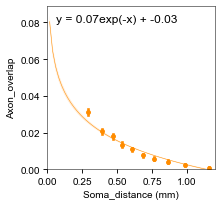

In [15]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0,1.2))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_"+group+"_v2.pickle", 'wb'))